In [11]:
!pip install denoising-diffusion-pytorch

In [12]:
# === Imports ===
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# === Device setup ===
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
# === Hyperparameters ===
LEARNING_RATE = 4e-4
BATCH_SIZE = 64
N_EPOCHS = 100
IMAGE_SIZE = 28
TIME_STEPS = 1000            # number of steps in forward process
SAMPLING_TIMESTEPS = 250     # fewer steps for reverse process (DDIM)
SAVE_AND_SAMPLE = True

In [14]:
# === Data loading ===
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor in range [0, 1]
])

# Load training set
dataset = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
# === Define U-Net model ===
# This U-Net predicts εθ(x_t, t), the standard normal noise used in the forward diffusion step
# Input shape: [B, 1, 28, 28]
model = Unet(
    dim=32,                  # base hidden dimension
    dim_mults=(1, 2, 4),     # progressively increase feature depth (tells the U-Net how to scale up the number of channels at each downsampling step)
    channels=1               # grayscale MNIST
).to(DEVICE)


In [16]:
# === Define DDPM logic ===
# This handles the forward process q(x_t | x₀) and reverse process pθ(x_{t-1} | x_t)

diffusion = GaussianDiffusion(
    model=model,
    image_size=IMAGE_SIZE,
    timesteps=TIME_STEPS, #forward steps
    sampling_timesteps=SAMPLING_TIMESTEPS # for faster generation
).to(DEVICE)



In [17]:
# === Optimizer ===
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [18]:
# === Training loop ===
epochs = tqdm(range(N_EPOCHS))
for epoch in epochs:
    model.train()
    total_loss = 0

    for batch_idx, (x0, _) in enumerate(loader):
        # x0: original image, shape [B, 1, 28, 28]
        x0 = x0.to(DEVICE)

        # loss = E_t[||ε - εθ(x_t, t)||²]
        # internally: generates t, creates x_t, and returns MSE loss
        loss = diffusion(x0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{N_EPOCHS}, Average Loss: {total_loss / len(loader):.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Average Loss: 0.0785
Epoch 2/100, Average Loss: 0.0459
Epoch 3/100, Average Loss: 0.0432
Epoch 4/100, Average Loss: 0.0405
Epoch 5/100, Average Loss: 0.0399
Epoch 6/100, Average Loss: 0.0393
Epoch 7/100, Average Loss: 0.0386
Epoch 8/100, Average Loss: 0.0382
Epoch 9/100, Average Loss: 0.0381
Epoch 10/100, Average Loss: 0.0375
Epoch 11/100, Average Loss: 0.0373
Epoch 12/100, Average Loss: 0.0377
Epoch 13/100, Average Loss: 0.0369
Epoch 14/100, Average Loss: 0.0367
Epoch 15/100, Average Loss: 0.0366
Epoch 16/100, Average Loss: 0.0364
Epoch 17/100, Average Loss: 0.0366
Epoch 18/100, Average Loss: 0.0363
Epoch 19/100, Average Loss: 0.0364
Epoch 20/100, Average Loss: 0.0362
Epoch 21/100, Average Loss: 0.0361
Epoch 22/100, Average Loss: 0.0359
Epoch 23/100, Average Loss: 0.0361
Epoch 24/100, Average Loss: 0.0360
Epoch 25/100, Average Loss: 0.0356
Epoch 26/100, Average Loss: 0.0358
Epoch 27/100, Average Loss: 0.0356
Epoch 28/100, Average Loss: 0.0357
Epoch 29/100, Average Loss: 0

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

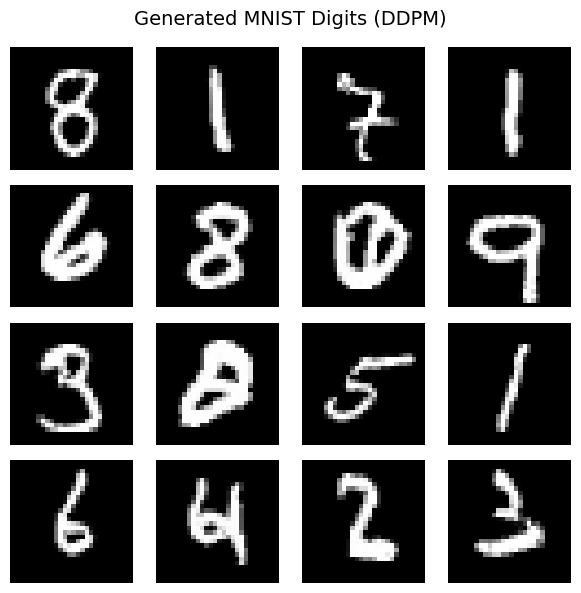

In [19]:
# === Sampling: generate new digits ===
if SAVE_AND_SAMPLE:
    model.eval()
    with torch.no_grad():
        # This starts from pure Gaussian noise and denoises to generate images
        # sampled_images: shape [16, 1, 28, 28]
        sampled_images = diffusion.sample(batch_size=16)

    # === Plot results ===
    sampled_images = sampled_images.cpu().numpy()

    fig, axs = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axs.flat):
        ax.imshow(sampled_images[i, 0], cmap='gray')
        ax.axis("off")
    plt.suptitle("Generated MNIST Digits (DDPM)", fontsize=14)
    plt.tight_layout()
    plt.show()